## References

 Inkawhich, Nathan. “DCGAN Tutorial¶.” DCGAN Tutorial - PyTorch Tutorials 1.7.1 Documentation, Pytorch, 2017, pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html?fbclid=IwAR3UQJhOBXg1YfPO0hhoHShO2NN4--mnaGb0qTGefjcqg5rp0PMpsbK6HFQ. 
 
 powerpoints on nyu classes

# Generative Adversarial Network (GAN)
Since GANs were introduced in 2014 by Google Researcher Ian Goodfellow, the tech has been widely adopted in image generation and transfer. After some early wiry failures, GANs have made huge breakthroughs and can now produce highly convincing fake images of animals, landscapes, human faces, etc. Researchers know what GANs can do, however a lack of transparency in their inner workings means GAN improvement is still achieved mainly through trial-and-error. This allows only limited control over the synthesized images

-------------
## Packages
Let's first import the necessary packages,

In [20]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets as dat_s

-----
## GPU Device Configuration
Then, we set up and configure our computational devices: 
Whether we use GPU or perform the calculation on CPU.
we use the torch.devices() and torch.cude.is_available() functions to configure our computational devices

In [21]:
torch.cuda.is_available()
comp_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(comp_device)

cuda


-----
## Configuration
### hyper parameters
We then set up and hyper parameters that need for the our model.
we need to define several hyper parameters for our model:
1. latent size
2. hidden size
3. input image size
4. numbper of epoches
5. batch size
6. out put directory

In [22]:
l_rate = 0.0001
hidden_size=256
latent_size=100
image_size=64*64*3
batch_size = 32
n_epoch = 20 #can be changed, used for efficiency
filename = "./out_dir"

Create a directory if not exists
using os.path.exists() to check whether it is exist
using os.makedires to create a directory.

In [23]:
if not os.path.exists(filename):
    os.makedirs(filename)

-----
##  Image processing
Then, we define a image preprocessing object that our dataloader can directly use this object to preprocess our data
We use the pytorch API to preform the data processing.
1. Use transforms.Compose()
2. Use transforms.CenterCrop(160) 
3. Use transforms.Scale(64)


In [24]:
celebs = dat_s.ImageFolder(root="/home/mmvc/img", transform=transforms.Compose([
                            transforms.CenterCrop(160),   
                            transforms.Resize(64),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

-----
##  Data Loading
Next, we are going to load our data. 
### First, we need to prepare our data:
#### we use the following command to download our data:
1. apt-get install p7zip-full # ubuntu

2. brew install p7zip # Mac

3. python download.py
-----
### We first import necessary librarys for data loading

In [25]:
import numpy as np
import os.path
from glob import glob
from PIL import Image
from tqdm import tqdm
import torchvision.datasets as dset
import torch.utils.data as data

### We first define several helper functions that can help use to load each item in the dataset .
1. We first create a list that contains all image files.    '.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',.

2. We then define a function called is_image_file() which takes the file name as the input:
    <br />a. We 1 if it is a valid image file.
    <br />b. Otherwise we return 0.
    
3. We next define a make_dataset() function which takes a file path as the input:
    <br />a. We go over the path
    <br />b. If it is a valid img file, store it to a list
    <br />c. Return the list
    
4. Finally, we create a function that is called default_loader()
    <br />a. that will open the image and conver it to the RGB using Image.open() and convert()

In [26]:
dataloader_img = torch.utils.data.DataLoader(celebs, batch_size=1,shuffle=True, num_workers=1)

### We then can use those helper functions to create our dataloader that load each item.  This function is called ImageFloder(data.Dataset) 
1. This function is initlize with root, transform, traget transform and loader
    <br /> a. get all imgs using the correct func we define above
    <br /> b. if no valide imgs: raise an proper error
    <br /> c. print the length of valid data



2. We need to define a __getitem__() function that take index as input
    <br /> a. for the "index" element in the img list
         i. if the transform is not none
             we transform the img using the transofrm
         ii. if the traget transform is not none:
             same.
    <br /> b. return the img and target.




3. We deine a __len__() function that retrun the length of the dataset


In [27]:
img, target = dataloader_img.dataset.__getitem__(202598)
print(img.size())

print("Dataset Size: ", len(dataloader_img))

torch.Size([3, 64, 64])
Dataset Size:  202599


### We then define our data loader get_loader()
#### This func has 6 arguments
1. root
2. split
3. batch size
4. scale size
5. number of workers
6. shuffle



<br />We first store the return value of os.path.basename of root to a variable
<br />Then we store the path to the image root
        <br /> 1. if the dataset_name is in CelebA:
        <br /> 2. then, we using the ImageFolder object we define above with transform.CenterCrop(160) to store the data
        <br /> 3. otherwise, we do not add the transfrom.CenterCrop when storing the data
<br />Finally, we create a data_loade using torch.utils.data.DataLoader() with proper parameters and set the proper shape of this data_loader using data_loade.shape=?

Then, we use the function above to load the data to the variable

In [28]:
data_loader = data.DataLoader(dataset = celebs, batch_size = batch_size, shuffle=True, num_workers=2, drop_last = True)

-----
##  Network
Next, we are going to design our GAN
We use the pytorch function nn.Sequential() to stack several layers as well as activation functions
### First, we need to create our discriminator
1. We need one input layer, one hidden layers and one out put layer. All of them are defined using nn.Linear() with proper input dim and out dim


2. We adopt nn.LeakyReLU(0.2) as activation layer for the input and hidden layer. 


3. We use nn.Sigmoid() activation function for the output layer

### Next, we are going to define our generator 
1. We need one input layer, one hidden layers and one out put layer. All of them are defined using nn.Linear() with proper input dim and out dim


2. We adopt nn.ReLU() as activation layer for the input and hidden layer. 


3. We use nn.Tanh() activation function for the output layer


#### Please First construct the generator module as follow:
1.	The input of the first linear layer is the latent vector size, output of the first layer is 256
2.	Then followed by a ReLU layer.
3.	The input of the second layer is the 256 and output channel is 512
4.	Followed by the ReLU layer
5.	The input of the third layer is the 512 and output channel is 1024
6.	Followed by the ReLU layer
7.	The input of the fourth layer is the 1024 and output channel is 1024
8.	Followed by the ReLU layer
9.	The input of the final layer is the 1024 and output channel is the image size.
10.	The Tanh is activation function.

#### Please First construct the discriminator module as follow:
1.	The input of the first linear layer is the image size, output of the first layer is 256
2.	Then followed by a LeakyReLU layer.
3.	The input of the second layer is the 256 and output channel is 512
4.	Followed by the leakyReLU layer
5.	The input of the third layer is the 512 and output channel is 512
6.	Followed by the leakyReLU layer
7.	The input of the final layer is the 512 and output channel is 1
8.	The sigmoid is activation function.


In [29]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.main = nn.Sequential(
            nn.Linear(latent_size, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 1024),
            nn.ReLU(True),
            nn.Linear(1024, image_size),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.main = nn.Sequential(
            nn.Linear(image_size, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

### Next, we send the network to the target device

In [30]:
networkg = Generator().to(comp_device)
networkd = Discriminator().to(comp_device)

if comp_device == 'cuda':
    networkg = torch.nn.DataParallel(networkg)
    networkd = torch.nn.DataParallel(networkd)
    cudnn.benchmark = True


### Finally, We set the Binary cross entropy loss and optimizer with proper netwrok parameters and learning rates

In [31]:
import torch.optim as optim

# Initialize BCELoss function
criterion = nn.BCELoss()

# Setup Adam optimizers for both G and D
optimizerd = optim.Adam(networkd.parameters(), lr=l_rate)
optimizerg = optim.SGD(networkg.parameters(), lr=l_rate)

optimizerd.zero_grad()
optimizerg.zero_grad()

-----
##  Training
Then, we are going to train our Network
### We first starting with two helper function
1. We frist implement the denorm function using clamp() api from pytorch please refer https://pytorch.org/docs/stable/torch.html?highlight=clamp#torch.clamp
2. We define a function that reset all the gradient of the optimziers.

In [32]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

### Start training
1. we first store the total steps which is equal to the length of data_loader
2. for each epoch
    <br/> a. for each element index and element in the data loader
        i. we reshape the input data to (batch_size，-1) and send to the proper device
        ii. then we create the real and fake labels which are later used as input for the BCE loss using torch.ones(batch_size, 1).to(device) and torch.zeros(batch_size, 1).to(device)
        iii. then we train the descriminator
            A. feedforward and store the predictions of discriminator
            B. compute BCE_Loss using real images and store the loss
            C. random init a latent code z
            D. feedforward and store the predictions of generator
            E. feed the predictions to the descriminator and sotre the prediction
            F. compute BCELoss using fake images and store the loss
            G. perofrm the backprop using losses after that reset the gradient of optimzier.
        iv. then we train the generator
            A. using torch.randn(batch_size, latent_size).to(device) to init a z
            B. feedforward and store the predictions of generator
            C. feed the predictions to the descriminator and sotre the prediction
            D. compute BCE_Loss using real images and store the loss
            F. perofrm the backprop using losses after that reset the gradient of optimzier.
        v. some centain period, we prient the log with proper info
    <br/> b. we store all real image with shape (images.size(0), 1, 28, 28) inoder for the further comparision only once
    <br/> c. we save the fake image with image shape (images.size(0), 1, 28, 28) and denorm() function 
3. Save the model checkpoints using torch.save()


In [33]:
total_steps = len(data_loader)
g_loss = []
d_loss = []

for epoch in range(n_epoch):
    for i,data in enumerate(data_loader):
            optimizerd.zero_grad()
            optimizerg.zero_grad()
        
        #we reshape the input data to (batch_size，-1) and send to the proper device
            data = torch.reshape(data[0],(batch_size, -1))
            data = data.to(comp_device)

        
        #then we create the real and fake labels which are later used as input for the 
        #BCE loss using torch.ones(batch_size, 1).to(device) and torch.zeros(batch_size, 1).to(device)
            real_l = torch.ones(batch_size,).to(comp_device)
            fake_l = torch.zeros(batch_size,).to(comp_device)
        
        #then we train the descriminator
     #A. feedforward and store the predictions of discriminator
            outputr = networkd(data).view(-1)
            errD_real = criterion(outputr, real_l)
            errD_real.backward()
        
        #random init a latent code z
            lv = torch.randn(batch_size,latent_size).to(comp_device)
        
        #feedforward and store the predictions of generator
            out_gF = networkg(lv)
        
        #feed the predictions to the descriminator and sotre the prediction
            outputf = networkd(out_gF).view(-1)
            errD_fake = criterion(outputf, fake_l)
            errD_fake.backward()
        
        #compute BCELoss using fake images and store the loss
            errD = errD_real + errD_fake
        
        #perofrm the backprop using losses after that reset the gradient of optimzier.
            optimizerd.step()
        
            optimizerd.zero_grad()
            optimizerg.zero_grad()
        
        #then we train the generator
     #A. using torch.randn(batch_size, latent_size).to(device) to init a z
    
            lv = torch.randn(batch_size,latent_size).to(comp_device)   
        
            #B. feedforward and store the predictions of generator
            out_gF = networkg(lv)
        
            #C. feed the predictions to the descriminator and sotre the prediction
            outputf = networkd(out_gF).view(-1)
        
            #D. compute BCE_Loss using real images and store the loss
            errG_real = criterion(outputf, real_l)
            errG_real.backward()
        
            #F. perofrm the backprop using losses after that reset the gradient of optimzier.
            optimizerg.step()
        
            optimizerd.zero_grad()
            optimizerg.zero_grad()
        
            # Save Losses for plotting later
            g_loss.append(errG_real.item())
            d_loss.append(errD.item())
            if (i%500 == 0):
                print('\nEpoch {}, Index {}, GenLoss {}, DiscLoss {}'.format(epoch+1,i,errG_real.item(),errD.item()))
      ##b. we store all real image with shape (images.size(0), 1, 28, 28) inoder for the further comparision only once
    if (epoch == 0):
        real_images = data.reshape(data.size(0), 3, 64, 64)
        save_image(denorm(real_images), os.path.join(filename, 'real.png'))
    
    ## c. we save the fake image with image shape (images.size(0), 1, 28, 28) and denorm() function
    fake_images = out_gF.reshape(out_gF.size(0), 3, 64, 64)
    save_image(denorm(fake_images), os.path.join(filename, 'fake.png'))
    
torch.save(networkg.state_dict(), filename+"/generator")
torch.save(networkd.state_dict(), filename+"/discriminator")


Epoch 1, Index 0, GenLoss 0.6888335347175598, DiscLoss 1.3745349645614624

Epoch 1, Index 500, GenLoss 6.181506156921387, DiscLoss 0.002157350303605199

Epoch 1, Index 1000, GenLoss 7.870314598083496, DiscLoss 0.0004001879133284092

Epoch 1, Index 1500, GenLoss 6.234555244445801, DiscLoss 0.002513469662517309

Epoch 1, Index 2000, GenLoss 4.200990200042725, DiscLoss 0.0089495237916708

Epoch 1, Index 2500, GenLoss 4.362092018127441, DiscLoss 0.05449609458446503

Epoch 1, Index 3000, GenLoss 6.2295637130737305, DiscLoss 0.0019622338004410267

Epoch 1, Index 3500, GenLoss 7.086174964904785, DiscLoss 0.0012091835960745811

Epoch 1, Index 4000, GenLoss 6.826720237731934, DiscLoss 0.001345864380709827

Epoch 1, Index 4500, GenLoss 12.198116302490234, DiscLoss 5.7220640883315355e-06

Epoch 1, Index 5000, GenLoss 7.7083516120910645, DiscLoss 0.000528842443600297

Epoch 1, Index 5500, GenLoss 8.206317901611328, DiscLoss 0.001208184752613306

Epoch 1, Index 6000, GenLoss 8.654129028320312, Dis

/home/mmvc/.conda/envs/cv19F/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


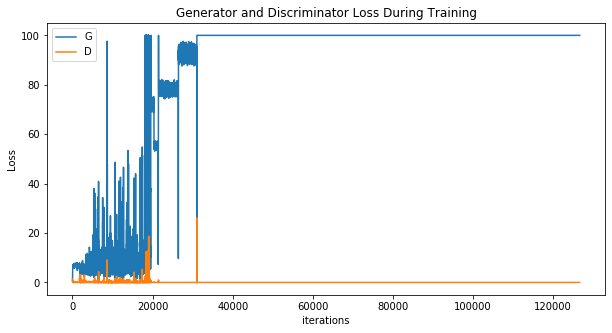

In [34]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_loss,label="G")
plt.plot(d_loss,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
